### Importing libraries

In [2]:
from ctypes import *              # import the C compatible data types
import time
from sys import platform, path    # this is needed to check the OS type and get the PATH
from os import sep                 # OS specific file path separators
import matplotlib.pyplot as plt
import numpy
import datetime
import os
import sys

### Platform agnostic SDK initialization

In [3]:
if sys.platform.startswith("win"):
    dwf = cdll.dwf
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else:
    dwf = cdll.LoadLibrary("libdwf.so")

constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
path.append(constants_path)
import dwfconstants as constants

In [ ]:
device_count = c_int()
dwf.FDwfEnum(c_int(), byref(device_count))
hdwf=c_int()
dwf.FDwfDeviceOpen(c_int(0), byref(hdwf))

In [16]:
filter_flags = c_int(constants.enumfilterType.value | constants.enumfilterUSB.value) # flags to show usb devices only
filter_flags = c_int(filter_flags.value | constants.enumfilterDemo.value) # flags to include demo devices ; comment this line to exclude
# Enumerate devices
device_count = c_int()
dwf.FDwfEnum(filter_flags, byref(device_count))
print(f"Number of devices found: {device_count.value}")
# Retrieve device name (optional)
name_buf = create_string_buffer(64) # buffer to store device name
sn_buf = create_string_buffer(32) # buffer to store device serial nmber
opn_status = c_int() # to store device opening status
status_lookup = lambda code: {
    0: "Not opened",
    1: "Opened by current process",
    2: "Opened by another process"
}.get(code, "Unknown status")

for i in range(device_count.value):
    dwf.FDwfEnumDeviceName(c_int(i), name_buf)
    dwf.FDwfEnumSN(c_int(i), sn_buf)
    dwf.FDwfEnumDeviceIsOpened(c_int(i),byref(opn_status))
    print(f"Detected device {i}\nname: {name_buf.value.decode()}\nserial: {sn_buf.value.decode()}\n{status_lookup(opn_status.value)}\n")
hdwf = c_int()
idx=int(input())
dwf.FDwfEnumDeviceIsOpened(c_int(idx),byref(opn_status))
if(opn_status.value==0):
    dwf.FDwfDeviceOpen(c_int(idx), byref(hdwf))
    if hdwf.value == 0:
        raise RuntimeError("Failed to open device.")
    print(f"device opened successfully!")
else:
    print(status_lookup(opn_status.value))

Number of devices found: 16
Detected device 0
name: Analog Discovery 3
serial: SN:210415BC9A47
Opened by current process

Detected device 1
name: Analog Discovery 3
serial: DEMO
Not opened

Detected device 2
name: Analog Discovery Pro 2230
serial: DEMO
Not opened

Detected device 3
name: Analog Discovery Pro 3250
serial: DEMO
Not opened

Detected device 4
name: Analog Discovery Pro 3450
serial: DEMO
Not opened

Detected device 5
name: Analog Discovery Pro 5250
serial: DEMO
Not opened

Detected device 6
name: Analog Discovery Pro 5470
serial: DEMO
Not opened

Detected device 7
name: Analog Discovery Pro 5490
serial: DEMO
Not opened

Detected device 8
name: Analog Discovery Studio Max
serial: DEMO
Not opened

Detected device 9
name: Digital Discovery
serial: DEMO
Not opened

Detected device 10
name: Discovery Power Supply 3340
serial: DEMO
Not opened

Detected device 11
name: Eclypse Z7
serial: DEMO
Not opened

Detected device 12
name: Analog Discovery
serial: DEMO
Not opened

Detected d

Opened by current process


In [41]:
dwf.FDwfAnalogInReset(hdwf)
dwf.FDwfDeviceCloseAll()
dwf.FDwfDeviceClose(hdwf)

0

Starting oscilloscope
Acquisition done
DC: 0.012256687868782128V


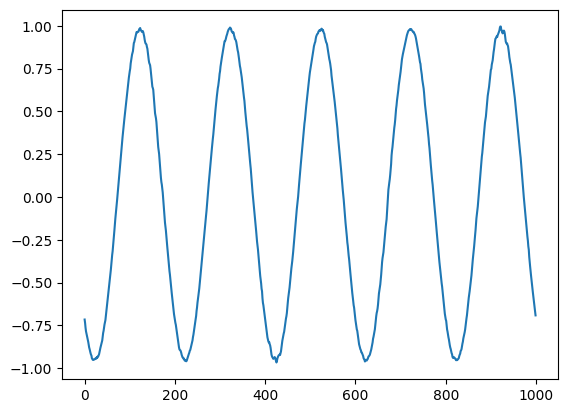

In [15]:
sampling_frequency = 20e05
buffer_size = 1000
amplitude_range = 5
offset = 0
sts = c_byte()
rgdSamples = (c_double*c_int(buffer_size).value)()

# the device will only be configured when FDwf###Configure is called
dwf.FDwfDeviceAutoConfigureSet(hdwf, c_int(0))

# enable channel 1
dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(0), c_bool(True))
 
# set offset voltage (in Volts)
dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(0), c_double(offset))
 
# set range (maximum signal amplitude in Volts)
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(amplitude_range))
 
# set the buffer size (data point in a recording)
dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(buffer_size))
 
# set the acquisition frequency (in Hz)
dwf.FDwfAnalogInFrequencySet(hdwf,c_double(sampling_frequency))
 
# disable averaging (for more info check the documentation)
dwf.FDwfAnalogInChannelFilterSet(hdwf, c_int(-1), constants.filterDecimate)

dwf.FDwfAnalogInConfigure(hdwf, c_int(1),c_int(0))

time.sleep(2)

print("Starting oscilloscope")
dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(1))

while True:
    dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
    if sts.value == constants.DwfStateDone.value :
        break
    # time.sleep(0.1)
print("Acquisition done")

dwf.FDwfAnalogInStatusData(hdwf, 0, rgdSamples, c_int(buffer_size).value) # get channel 1 data

#plot window
dc = sum(rgdSamples)/len(rgdSamples)
print("DC: "+str(dc)+"V")

plt.plot(numpy.fromiter(rgdSamples, dtype = numpy.float64))
plt.show()

In [7]:
wavegen_frequency = 1e4
wavegen_dc = 0.0
wavegen_amplitude = 1.0

# Enable the waveform generator output (channel 0, node 0)
# - hdwf: device handle
# - 0: channel index
# - 0: node (main signal path, typically "Carrier")
# - 1: enable (True)
dwf.FDwfAnalogOutNodeEnableSet(hdwf, 0, 0, 1)

# Set the waveform type to sine wave
# - funcSine: predefined constant for sine waveform
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, 0, 0, constants.funcSine)

# Set the frequency of the output sine wave to 10,000 Hz (10 kHz)
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, 0, 0, c_double(wavegen_frequency))

# Set the DC offset of the waveform to 0 V (centers it around 0)
dwf.FDwfAnalogOutNodeOffsetSet(hdwf, 0, 0, c_double(wavegen_dc))

# Set the peak amplitude of the sine wave to 1 V
# (i.e., the wave will swing from -1V to +1V)
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, 0, 0, c_double(wavegen_amplitude))

# Start the output signal
# - 0: channel index
# - 1: start (True)
dwf.FDwfAnalogOutConfigure(hdwf, 0, 1)

1